In [31]:
import os
import sys
import random
import warnings
import time
import pprint as pp
from keras import layers
from keras import models
from time import strftime, gmtime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [13]:
from IPython import get_ipython

ip = get_ipython()

if ip == None:
    print('Python Script from notebook is running.')
    plt.switch_backend('agg')
else:
    print('Notebook is running.')

Notebook is running.


In [4]:
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [14]:
import os

from os import walk
import copy

path = './datapack_images/Global/Foram_TSCLite_Images'

file_names = None
for (dirpath, dirnames, fnames) in walk(path):
    file_names = fnames

single_image_file = []
multiple_image_file = []
genus_single = []
species_single = []
genus_multiple = []
species_multiple = []

for f in file_names:
    forig = copy.copy(f)
    if ' ' in f:
        f = f.split(' ')
    elif '_' in f:
        f = f.split('_')
    if 'tiny' in forig and len(f) != 2:
        #print('single = ' + str(f))
        single_image_file.append(forig)
        genus_single.append(f[0])
        species_single.append(f[1])
    else:
        #print('multi = ' + str(f))
        multiple_image_file.append(forig)
        genus_multiple.append(f[0])
        fm = f[1].split('.')[0]
        species_multiple.append(fm)

        
        
'''

print(genus_single)
print(species_single)
print('')
print(genus_multiple)
print(species_multiple)

'''


for i, f in enumerate(single_image_file):
    s = str(genus_single[i]) + ', ' + str(f)
    #print(s)
    
#print(len(genus_single))
#print(genus_multiple)

Let's use only 10 classes (10 different genus).

I have 10 single images. Let's augment image data.

In [15]:
# multi_cls: Dict keyed by the unique genus name and for each genus name the index of the image file from 236 files
# final_cls: Dict keyed by the unique genus names, values indicate the index of the first image file with the same genus

# classes: Dict gives the unique genus/class id for 236 genus files, keyed from 0 to 236 (236 image files)
# class_names: Dict gives the unique genus/class id for 236 genus files, keyed by the unique genus name
# uniq_cls: list gives the unique genus names

# 79 different classes
cls = genus_single
file_names = single_image_file
multi_cls = {}
final_cls = {}
k = 0
for j, cl in enumerate(cls):
    if cl in multi_cls.keys():
        multi_cls[cl].append(j)
    else:
        a = [j]
        multi_cls[cl] = a
        final_cls[cl] = k
        k += 1
    
print(multi_cls)
print("")
print(final_cls)
print("")

classes = {}
class_names = {}
for k in multi_cls.keys():
    clss = multi_cls[k]
    for c in clss:
        classes[c] = final_cls[k]
        class_names[c] = k
     
print(classes)
print("")
print(class_names)

uniq_cls = uniq_genus = list(multi_cls.keys())

print("")
print(uniq_cls)
        
#print(cls)
#print(file_names)

{'Globorotalia': [0, 4, 5, 15, 35, 42, 51, 54, 74, 78, 103, 111, 117, 124, 127, 138, 141, 145, 147, 148, 157, 160, 170, 180, 186, 190, 214, 227, 234], 'Hedbergella': [1, 188], 'Globigerinoides': [2, 11, 23, 45, 80, 106, 125, 140, 181, 203, 219, 226], 'Cribrohantkenina': [3], 'Globoturborotalita': [6, 43, 152, 156, 182], 'Globigerina': [7, 33, 52, 53, 98, 101, 107, 194, 211], 'Morozovella': [8, 14, 47, 61, 66, 70, 76, 77, 130, 137, 164, 193], 'Acarinina': [9, 25, 26, 37, 40, 83, 95, 121, 132, 206, 216, 224], 'Thalmanninella': [10, 69], 'Tenuitella': [12, 30, 213], 'Sigalia': [13], 'Praemurica': [16, 126], 'Planorotalites': [17], 'Clavatorella': [18], 'Turborotalia': [19, 20, 116, 179, 207, 223], 'Globotruncana': [21, 86, 142, 225], 'Microhedbergella': [22, 129, 189], 'Ventilabrella': [24], 'Pseudoguembelina': [27, 96, 165, 204], 'Pseudohastigerina': [28, 200, 228], 'Globanomalina': [29, 110, 201, 218], 'Whiteinella': [31, 104, 108, 109], 'Pseudothalmanninella': [32, 123], 'Pulleniatina'

In [16]:
# Link: https://gist.github.com/oeway/2e3b989e0343f0884388ed7ed82eb3b0

import numpy as np
import scipy
import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
import collections
from PIL import Image
import numbers
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util


def center_crop(x, center_crop_size):
    assert x.ndim == 2
    centerw, centerh = x.shape[0] // 2, x.shape[1] // 2
    halfw, halfh = center_crop_size[0] // 2, center_crop_size[1] // 2
    return x[centerw - halfw:centerw + halfw, centerh - halfh:centerh + halfh]

def center_crop_rgb(x, center_crop_size):
    assert x.ndim == 3
    centerw, centerh = int(x.shape[0] // 2), int(x.shape[1] // 2)
    halfw, halfh = int(center_crop_size[0] // 2), int(center_crop_size[1] // 2)
    
    chan = x.shape[2]
    xr = np.zeros((int(center_crop_size[0]), int(center_crop_size[1]), chan))
    
    for c in range(chan):
        xr[0:int(center_crop_size[0]), 0:int(center_crop_size[1]), c] = x[centerw - halfw:centerw + halfw, centerh - halfh:centerh + halfh, c]
        
    return xr

def rotate(image_array: ndarray, degree):
    return sk.transform.rotate(image_array, degree)

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def vertical_flip(image_array: ndarray):
    return np.flipud(image_array)


In [19]:
# Load image data from file
# And augment images
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
import cv2 as cv

img_width = 331 #128 * 2 * 2
img_height = 331 #128 * 2 * 2
img_chan = 3

#plt.figure(figsize=(20,10))
train_imgs = []
train_lbls = []
for j, fname in enumerate(file_names):
    img = load_img(path + '/' + fname)
    # converting to numpy array
    imga = np.array(img)
    
    # reshaping to same size using the power of cv
    imgr = cv.resize(imga, (img_width, img_height), interpolation=cv.INTER_AREA)
    #print(imgr.shape)
    train_imgs.append(imgr)
    clas = final_cls[class_names[j]]
    train_lbls.append(clas)
    
    #plt.subplot((j%10) + 1,len(file_names), (j%10) + 1)
    print(j)
    print(class_names[j])
    #plt.imshow(train_imgs[j])

    #plt.show()

train_lbls = to_categorical(train_lbls)


0
Globorotalia
1
Hedbergella
2
Globigerinoides
3
Cribrohantkenina
4
Globorotalia
5
Globorotalia
6
Globoturborotalita
7
Globigerina
8
Morozovella
9
Acarinina
10
Thalmanninella
11
Globigerinoides
12
Tenuitella
13
Sigalia
14
Morozovella
15
Globorotalia
16
Praemurica
17
Planorotalites
18
Clavatorella
19
Turborotalia
20
Turborotalia
21
Globotruncana
22
Microhedbergella
23
Globigerinoides
24
Ventilabrella
25
Acarinina
26
Acarinina
27
Pseudoguembelina
28
Pseudohastigerina
29
Globanomalina
30
Tenuitella
31
Whiteinella
32
Pseudothalmanninella
33
Globigerina
34
Pulleniatina
35
Globorotalia
36
Parasubbotina
37
Acarinina
38
Praeorbulina
39
Cassigerinella
40
Acarinina
41
Astrorotalia
42
Globorotalia
43
Globoturborotalita
44
Globuligerina
45
Globigerinoides
46
Hantkenina
47
Morozovella
48
Helvetoglobotruncana
49
Planoglobulina
50
Planulina
51
Globorotalia
52
Globigerina
53
Globigerina
54
Globorotalia
55
Globigerinelloides
56
Globigerinelloides
57
Globuligerina
58
Globigerinatheka
59
Globuligerina
60

In [20]:
print(np.array(train_lbls).shape)

(236, 79)


In [21]:
# Image Data Augmentation
from copy import copy


nrow = 3
ncol = 13

#f, ax = plt.subplots(nrow, ncol, figsize=(20, 20))
aug_images = []
aug_labels = []
for j, img in enumerate(train_imgs):
    #ax[j][0].imshow(img)
    
    #center crop
    crop_size = (3*img_width/4, 3 * img_height/4, img_chan)
    img_cc = copy(center_crop_rgb(img, crop_size))
    #aug_images.append(img_cc)
    #aug_labels.append(train_lbls[j])
    
    #ax[j][1].imshow(img_cc)
    
    # horizontal flip
    img_hf = horizontal_flip(img)
    aug_images.append(img_hf)
    aug_labels.append(train_lbls[j])
    #ax[j][2].imshow(img_hf)
    
    
    # vertical flip
    img_ud = vertical_flip(img)
    aug_images.append(img_ud)
    aug_labels.append(train_lbls[j])
    #ax[j][3].imshow(img_ud)
    
    # random rotation
    k=0
    for angle in range(15, 360, 45): # 8 different angles
        img_rr= copy(rotate(img, angle))
        aug_images.append(img_rr)
        aug_labels.append(train_lbls[j])
        #ax[j][4 + k].imshow(img_rr)
        k += 1
    #print(k)
    
    # random noise
    img_rn= random_noise(img)
    aug_images.append(img_rn)
    aug_labels.append(train_lbls[j])
    #ax[j][4 + k].imshow(img_rn)

aug_labels = np.array(aug_labels)
#plt.show()

In [11]:
aug_labels.shape

(2596, 79)

In [22]:
# get the main training image data
train_images = np.array(train_imgs)
# For Dense layers
#train_images = train_images.reshape(len(train_images), img_width * img_height * img_chan)
# For CNN
train_images = train_images.reshape(len(train_images), img_width, img_height, img_chan)
train_images = train_images.astype('float32') / 255

# convert into categorical y label
train_labels = np.array(train_lbls)


In [23]:
print(train_images.shape)
print(train_labels.shape)

(236, 331, 331, 3)
(236, 79)


In [24]:
def categorical_to_cls(train_label):
    for ix,x in enumerate(train_label):
        if x != 0:
            break
    
    return(ix)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
38
Praeorbulina


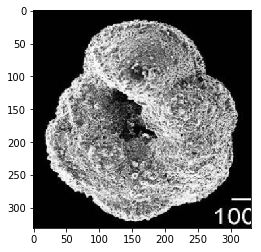

In [25]:
# Randomly select a training image and check the correctness of the genus class

ir = np.random.randint(0, train_labels.shape[0])

print(train_labels[ir])
cl = categorical_to_cls(train_labels[ir])
print(cl)
print(class_names[cl])
plt.imshow(train_images[ir])
plt.show()


In [26]:
aug_images_a = np.array(aug_images)
aug_labels_a = np.array(aug_labels)
print(aug_images_a.shape)
print(aug_labels_a.shape)

(2596, 331, 331, 3)
(2596, 79)


In [29]:
idxx = np.arange(len(aug_images_a))
print(idxx)
#np.random.shuffle(idxx)
#print(idxx)

[   0    1    2 ... 2593 2594 2595]
[2127 1895 1080 ... 1104 1993 2383]


In [28]:
# Keep the main images as the test images
test_images = train_images
test_labels = train_labels

In [ ]:
train_images_interim = aug_images_a[idxx,]
train_labels_interim = aug_labels_a[idxx,]
train_index = np.arange(len(train_images_interim))
print(train_index)

In [ ]:

#print(idxx)

# random shuffle so that in train_valid split classes can be spreaded
#
#print(idxx)

#print(aug_images_a[idxx,])
#print(aug_labels_a[idxx,])



# Use the augmented images as the intermediate images to use them as training and validation images later on

#train_labels_interim = aug_labels_a[idxx,]

#train_index = np.arange(len(train_images_interim))
#print(train_index)

In [ ]:
print(train_images_interim.shape)
print(train_labels_interim.shape)

print(test_images.shape)
print(test_labels.shape)

In [ ]:
from sklearn.model_selection import train_test_split

# stratify based on the label so that training and validation data has equal proportion for each class
validation_split = 0.25
train_ids, validation_ids, train_images, validation_images, train_labels, validation_labels = train_test_split(
    train_index,
    train_images_interim,
    train_labels_interim,
    test_size=validation_split,
    shuffle = True, # not needed, by default true
    stratify=train_labels_interim, 
    random_state=2347) # keep the same random state so that we can compare different models

print(train_images.shape)
print(validation_images.shape)
print(train_labels.shape)
print(validation_labels.shape)

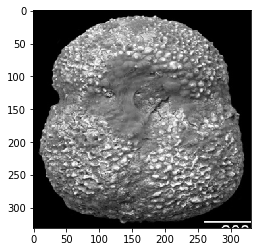

2
Globigerinoides


NameError: name 'validation_images' is not defined

In [30]:
train_img_random = np.random.randint(0,train_images.shape[0])

plt.imshow(train_images[train_img_random])
plt.show()
#print(train_labels[train_img_random])
cl = categorical_to_cls(train_labels[train_img_random])
print(cl)
print(class_names[cl])

validation_img_random = np.random.randint(0, validation_images.shape[0])

plt.imshow(validation_images[validation_img_random])
plt.show()
#print(validation_labels[validation_img_random])
cl = categorical_to_cls(validation_labels[validation_img_random])
print(cl)
print(class_names[cl])

In [ ]:
# Check how good is the stratification (class distribution in training and validation data)

tl = []
tlc = []
for x in train_labels:
    cl = categorical_to_cls(x)
    tlc.append(cl)
    
vl = []
vlc = []
for x in validation_labels:
    cl = categorical_to_cls(x)
    vlc.append(cl)    
    
print(len(tlc))
#print(tlc)
print("")
print(len(vlc))
#print(vlc)
print("")

bin_num = 80
th, tbin = np.histogram(tlc, bins=bin_num)
print(th)
print("")
vh, vbin = np.histogram(vlc, bins=bin_num)
print(vh)
print("")

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(tbin[0:bin_num], th)
plt.title('training data')
plt.subplot(1, 2, 2)
plt.plot(vbin[0:bin_num], vh)
plt.title('validation data  (Class/Genus distribution)')
plt.show()
    

In [ ]:
print(train_images.shape)
print(validation_images.shape)
print(test_images.shape)

print(train_labels.shape)
print(validation_labels.shape)
print(test_labels.shape)

In [ ]:
from keras import layers
from keras import models
from time import strftime, gmtime

cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime())
model_name='simple_convnet' + str(cur_time)

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), use_bias = False, activation='relu', input_shape=(img_width, img_height, img_chan)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), use_bias = False, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), use_bias = False, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten(input_shape = (img_width, img_height, img_chan)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
# model.add(layers.Flatten())
model.add(layers.Dense(len(uniq_cls), activation='sigmoid'))


model.summary()

In [34]:
cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime())
model_name='vgg19_extended_adam_two_fc_4096' + str(cur_time)
print(model_name)

vgg19_extended_adam_two_fc_40962019-03-21 19:04:43


In [35]:
cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime())

# Use pretrained modela
# Model 1

#from keras.applications import VGG16
#conv_base_vgg16 = VGG16(weights='imagenet',
#                  include_top=False,
#                  input_shape=(img_width, img_height, img_chan))

# Model 2

from keras.applications import VGG19
conv_base_vgg19 = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, img_chan))

# Model 3

from keras.applications import ResNet50

conv_base_resnet50 = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, img_chan))

# Model 4
#from keras.applications import InceptionV3

#conv_base_inceptionv3 = InceptionV3(weights='imagenet',
#                  include_top=False, 
#                  input_shape=(img_width, img_height, img_chan))

# Model 5
from keras.applications import InceptionResNetV2

conv_base_inceptionresnetv2 = InceptionResNetV2(weights = 'imagenet',
                                               include_top=False, 
                                               input_shape=(img_width, img_height, img_chan))

# Model 6
#from keras.applications import NASNetLarge

#conv_base_nasnet = NASNetLarge(weights = 'imagenet', 
#                                   include_top = False,
#                                 input_shape=(img_width, img_height, img_chan))

#conv_base = conv_base_vgg19
conv_base = conv_base_inceptionresnetv2
conv_base.summary()


/apps/gilbreth/ml/ml-toolkit/conda-5.1.0-py36/gpu/install/keras-2.2.4/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 165, 165, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 165, 165, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 165, 165, 32) 0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
from keras import regularizers

model = models.Sequential()
conv_base.trainable = False
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu')) #activity_regularizer=regularizers.l1(0.01)
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(uniq_cls), activation='sigmoid', kernel_regularizer=regularizers.l2(0.05)))

model.summary()

In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.utils import get_file
from keras import backend as K
import h5py

def VGG19_convolutions(input_shape = (331, 331, 3),
                       pooling=None,
                       classes=1000):

    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1', 
                      input_shape=input_shape))
   
    model.add(Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2'))
    
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    
    # Block 2
    model.add(Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1'))
    model.add(Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    # Block 3
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1'))
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2'))
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3'))
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    # Block 4
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    # Block 5
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

    if pooling == 'avg':
        model.add(GlobalAveragePooling2D())
    elif pooling == 'max':
        model.add(GlobalMaxPooling2D())
    
    return model

In [ ]:
VGG19_WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                             'releases/download/v0.1/'
                             'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
weights_path = get_file(
                    'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    VGG19_WEIGHTS_PATH_NO_TOP,
                    cache_subdir='models',
                    file_hash='6d6bbae143d832006294945121d1f1fc')


In [37]:
model = VGG19_convolutions()

model.load_weights(weights_path)
       
model.add(Flatten(name='flatten'))
model.add(Dense(4096, activation='relu', name='fc1'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', name='fc2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(uniq_cls), activation='sigmoid', kernel_regularizer=regularizers.l2()))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 331, 331, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 331, 331, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 165, 165, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 165, 165, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 165, 165, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 82, 82, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 82, 82, 256)       295168    
__________

In [13]:
models_dir='./models'

save_period=1
schedule = None

In [14]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from time import strftime, gmtime

cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime()) 
best_model_file = '{}/best_{}_{}.h5'.format(models_dir, model_name,cur_time)
print(best_model_file)

class ModelCheckpointMGPU(ModelCheckpoint):
    def __init__(self, original_model, filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1):
        self.original_model = original_model
        super().__init__(filepath, monitor, verbose, save_best_only, save_weights_only, mode, period)

    def on_epoch_end(self, epoch, logs=None):
        self.model = self.original_model
        super().on_epoch_end(epoch, logs)

def freeze_model(model, freeze_before_layer):
    if freeze_before_layer == "ALL":
        for l in model.layers:
            l.trainable = False
    else:
        freeze_before_layer_index = -1
        for i, l in enumerate(model.layers):
            if l.name == freeze_before_layer:
                freeze_before_layer_index = i
        for l in model.layers[:freeze_before_layer_index + 1]:
            l.trainable = False


best_model = ModelCheckpointMGPU(model, filepath=best_model_file, monitor='val_loss',
                                     verbose=1,
                                     mode='min',
                                     period=save_period,
                                     save_best_only=True,
                                     save_weights_only=True)
last_model_file = '{}/last_{}_{}.h5'.format(models_dir, model_name,cur_time)
print(last_model_file)

last_model = ModelCheckpointMGPU(model, filepath=last_model_file, monitor='val_loss',
                                     verbose=1,
                                     mode='min',
                                     period=save_period,
                                     save_best_only=False,
                                     save_weights_only=True)

callbacks = []
callbacks.append(best_model)
callbacks.append(last_model)

tb = TensorBoard("./logs/{}".format(model_name))
callbacks.append(tb)

./models/best_convbase_vgg19_img_dim_331_optimizer_adam_default_scheduling_both2019-03-19 15:52:06_2019-03-19 15:52:35.h5
./models/last_convbase_vgg19_img_dim_331_optimizer_adam_default_scheduling_both2019-03-19 15:52:06_2019-03-19 15:52:35.h5


In [15]:
from keras.optimizers import Adam, RMSprop,SGD

opt_pref = 'adam2'
learning_rate = 0.001
decay = 0.0

if opt_pref == 'adam':
    optimizer = 'adam'
elif opt_pref == 'adam2':
    optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay, amsgrad=False)
elif opt_pref == 'amsgrad':
    optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay, amsgrad=True)
elif opt_pref == 'rmsprop':
    optimizer = RMSprop(lr=learning_rate, decay = decay)
elif opt_pref == 'adamax':
    optimizer = AdaMax(lr=learning_rate, decay = decay)
elif opt_pref == 'sgd':
    optimizer = SGD(lr=learning_rate, decay=decay, momentum=0.9, nesterov=True)

In [16]:
epoch = 80
batch_size = 20

In [17]:
from keras.callbacks import ReduceLROnPlateau

def schedule_steps(epoch, steps):
    for step in steps:
        if step[1] > epoch:
            print("Setting learning rate to {}".format(step[0]))
            return step[0]
        print("Setting learning rate to {}".format(steps[-1][0]))
        return steps[-1][0]


steps = [(1e-6, 2), (1e-5, 10), (5e-6, 20), (3e-6, 25)]
if steps is not None:
    lrSchedule = LearningRateScheduler(lambda epoch: schedule_steps(epoch, steps))
    callbacks.insert(0, lrSchedule)

callbacks.append(lrSchedule)

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks.append(reduce_lr)

In [18]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#history = model.fit(train_images, train_labels, validation_data=(validation_images, validation_labels), epochs=epoch, batch_size=batch_size, callbacks=callbacks, verbose=1)
history = model.fit(train_images, train_labels, validation_split=0.30, epochs=epoch, batch_size=batch_size, callbacks=callbacks, verbose=1)

In [ ]:
# """
# Plotting multiple scalars on the same graph
# """
# from numpy import random
    
# writer_val = tf.summary.FileWriter("./logs/{}/plot_val".format(model_name))
# writer_train = tf.summary.FileWriter("./logs/{}/plot_train".format(model_name))
# loss_var = tf.Variable(0.0)
# tf.summary.scalar("loss", loss_var)
# write_op = tf.summary.merge_all()
# session = tf.InteractiveSession()
# session.run(tf.global_variables_initializer())
# for i in range(100):
#  # loss validation
#  summary = session.run(write_op, {loss_var: random.rand()})
#  writer_val.add_summary(summary, i)
#  writer_val.flush()
#  # loss train
#  summary = session.run(write_op, {loss_var: random.rand()})
#  writer_train.add_summary(summary, i)
#  writer_train.flush()

In [ ]:
# last model
# last_convbase_vgg19_img_dim_331_kernel_regularizer2018-10-28 02:20:00_2018-10-28 03:53:16.h5
model.load_weights(last_model_file)
res_last = model.evaluate(test_images, test_labels)
print(res_last)

# best model
# ./models/best_convbase_vgg19_img_dim_331_kernel_regularizer2018-10-28 02:20:00_2018-10-28 03:53:16.h5

model.load_weights(best_model_file)

res_best = model.evaluate(test_images, test_labels)
print(res_best)

In [ ]:
model.evaluate(test_images, test_labels)

In [ ]:
pred = model.predict(test_images, verbose=1)

In [ ]:
n = pred.shape[1]
print(n)
pred_cls_identity = np.eye(n)
idx = np.argmax(pred, axis=1)

# creating the predicted class from identity matrix
pred_cls = pred_cls_identity[idx]
print(pred_cls.shape)

In [ ]:
# Show the true and predicted class distribution

true_clss = [categorical_to_cls(tc) for tc in test_labels]
plt.hist(true_clss, bins=78)
plt.show()

pred_clss = [categorical_to_cls(pc) for pc in pred_cls]
plt.hist(pred_clss, bins = 78)
plt.show()

In [ ]:
# calculating accuracy

total_n = test_labels.shape[0]
pred_acc_t = [np.sum(test_labels[i] == pred_cls[i]) == n for i in np.arange(total_n)]
pred_acc_ix = [i for i in np.arange(total_n) if np.sum(test_labels[i] == pred_cls[i]) == n]
pred_err_t = [np.sum(test_labels[i] == pred_cls[i]) != n for i in np.arange(total_n)]
pred_err_ix = [i for i in np.arange(total_n) if np.sum(test_labels[i] == pred_cls[i]) != n]
pred_acc = np.sum(pred_acc_t)/total_n
pred_err = np.sum(pred_err_t)/total_n
print(pred_acc)
print(pred_err)

In [ ]:
# Errored images/classes

err_cls = []
err_cls_names = []

for i, err_img_ix in enumerate(pred_err_ix):
    #true
    plt.subplot(1,2, 1)
    plt.imshow(test_images[err_img_ix])
    cl = categorical_to_cls(test_labels[err_img_ix])
    print("true class = " + str(cl))
    print("true class name = " + str(class_names[cl]))
    err_cls.append(cl)
    err_cls_names.append(class_names[cl])
    
    #predicted
    pcl = categorical_to_cls(pred_cls[i])
    plt.subplot(1,2, 2)
    plt.imshow(test_images[pcl])
    print("predicted class = " + str(pcl))
    print("predicted class name = " + str(class_names[pcl]))
    
    plt.show()

In [ ]:
# which are the erred classes
err_cls_s = set(err_cls)
np.array(err_cls_s)
print(len(err_cls_s))
print(236-len(err_cls_s))

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()